## Zonal Costs

In [10]:
# Third-party packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Local imports
from utils import get_data
from utils import tech_order, tech_colors
from utils import get_data_sftp

from datetime import datetime
from pytz import timezone
import os

from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

plt.style.use("style.txt")
pd.options.display.float_format = '{:,.2f}'.format

### Scenarios

In [11]:
scenario = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14',
                 's15','s16','s17','s18','s19','s20','s21','s22','s23','s24','s25']
short_names={'s1':'1','s2':'2','s3':'3','s4':'4','s5':'5','s6':'6','s7':'7','s8':'8',
             's9':'9','s10':'10','s11':'11','s12':'12','s13':'13','s14':'14','s15':'15',
             's16':'16','s17':'17','s18':'18','s19':'19','s20':'20','s21':'21','s22':'22',
             's23':'23','s24':'24','s25':'25'}

order={'1':0, '2':1,'3':2,'4':3,'5':4,'6':5,'7':6,'8':7,'9':8,'10':9,'11':10,'12':11,
       '13':12,'14':13,'15':14,'16':15,'17':16,'18':17,'19':18,'20':19,'21':20,'22':21,
       '23':22,'24':23,'25':24}
folder_to_save_results='results_test/'

#Check if the directory exists. If not, then create the directory.
if not os.path.exists(folder_to_save_results):
    os.makedirs(folder_to_save_results)

In [12]:
#zones_under_analysis
# analysis_zones=['WA_SEATAC','WA_W','OR_W','CA_PGE_N','CA_PGE_BAY','CA_PGE_CEN',
#                 'CA_PGE_S','CA_SCE_CEN','CA_LADWP','CA_SCE_S','CA_SDGE','MEX_BAJA'] #these are coastal load zones
analysis_zones=['CA_SMUD', 'CA_SDGE', 'CA_IID', 'CA_LADWP', 'OR_WA_BPA', 'OR_PDX',
                'OR_W', 'OR_E', 'WA_W', 'CA_SCE_S', 'WA_SEATAC', 'CA_PGE_CEN',
                'CA_PGE_BAY', 'CA_PGE_S', 'CA_PGE_N', 'CA_SCE_SE', 'CA_SCE_VLY',
                'CA_SCE_CEN', 'WA_ID_AVA', 'WA_N_CEN']#these are coastal states
analysis_period=[2020,2030,2040,2050]

### Generation Fixed Costs

In [13]:
fname = "gen_cap.csv"

gen_cap = get_data(scenario, fname)
gen_cap = gen_cap[['GENERATION_PROJECT', 'PERIOD', 'gen_load_zone', 'gen_tech', 'GenCapitalCosts', 'GenFixedOMCosts', 'scenario']]
gen_cap  = gen_cap  .replace({"scenario": short_names})
gen_cap['GenFixedCosts'] = gen_cap['GenCapitalCosts'] + gen_cap['GenFixedOMCosts'] 
gen_cap= gen_cap.loc[(gen_cap.gen_load_zone.isin(analysis_zones)) & (gen_cap.PERIOD.isin(analysis_period))]
gen_cap

FileNotFoundError: [Errno 2] No such file or directory: '/data/switch/wave_cases_v2/s1/outputs/gen_cap.csv'

In [ ]:
storage_costs=gen_cap.copy()
storage_costs=storage_costs.loc[storage_costs.gen_tech.isin(['Battery_Storage'])]
storage_costs.rename(columns={'PERIOD':'period'},inplace=True)
storage_costs

year_storage_costs_by_scenario= storage_costs.pivot_table(
    index=['scenario','period'], values="GenFixedCosts", aggfunc=np.sum )
year_storage_costs_by_scenario.rename(columns={'GenFixedCosts':'StorageFixedCosts'}, inplace=True)

year_storage_costs_by_scenario['sc_order'] = year_storage_costs_by_scenario.index.get_level_values('scenario').map(order)
year_storage_costs_by_scenario=year_storage_costs_by_scenario.sort_values('sc_order').drop('sc_order',axis=1)
year_storage_costs_by_scenario


StorageFixedCosts
scenario period                   
1        2020                 0.00
         2030                 0.00
         2040       910,683,900.00
         2050     3,908,697,700.00
2        2040       859,760,600.00
...                            ...
24       2040        43,952,000.00
25       2020                 0.00
         2030                 0.00
         2050     2,856,489,000.00
         2040        49,915,000.00

[100 rows x 1 columns]

In [ ]:
year_genfixed_costs_by_scenario= gen_cap.rename(columns={'PERIOD':'period'})
year_genfixed_costs_by_scenario= year_genfixed_costs_by_scenario.pivot_table(
    index=['scenario','period'], values="GenFixedCosts", aggfunc=np.sum )

#sort according to order dictionary (defined above)
year_genfixed_costs_by_scenario['sc_order'] = year_genfixed_costs_by_scenario.index.get_level_values('scenario').map(order)
year_genfixed_costs_by_scenario=year_genfixed_costs_by_scenario.sort_values('sc_order').drop('sc_order',axis=1)

#year_genfixed_costs_by_scenario['GenFixedCosts']=year_genfixed_costs_by_scenario['GenFixedCosts']-year_storage_costs_by_scenario['StorageFixedCosts'] #commenting this out makes it match costs_itmized.csv
year_genfixed_costs_by_scenario

GenFixedCosts
scenario period                  
1        2020    1,187,326,992.00
         2030    4,640,379,371.00
         2040   10,346,569,309.00
         2050   21,710,583,139.00
2        2040   10,580,383,809.00
...                           ...
24       2040   14,741,088,099.00
25       2020    1,129,903,592.00
         2030    5,779,775,548.00
         2050   27,657,036,963.00
         2040   14,761,339,479.00

[100 rows x 1 columns]

In [ ]:
fname = "financials.csv"
financials = get_data(scenario, fname, fpath='inputs')
financials

,base_financial_year,interest_rate,discount_rate,scenario
0,2018,0.05,0.05,s1
0,2018,0.05,0.05,s2
0,2018,0.05,0.05,s3
0,2018,0.05,0.05,s4
0,2018,0.05,0.05,s5
0,2018,0.05,0.05,s6
0,2018,0.05,0.05,s7
0,2018,0.05,0.05,s8
0,2018,0.05,0.05,s9
0,2018,0.05,0.05,s10


In [ ]:
interest_rate = financials.loc[0,'interest_rate'].unique()[0]
discount_rate = financials.loc[0,'discount_rate'].unique()[0]
base_financial_year = financials.loc[0,'base_financial_year'].unique()[0]

In [ ]:
fname = "generation_projects_info.csv"
gen_proj_info = get_data(scenario, fname, fpath='inputs')
gen_proj_info = gen_proj_info.loc[gen_proj_info.gen_load_zone.isin(analysis_zones)]
gen_proj_info_batteries = gen_proj_info.loc[gen_proj_info.gen_tech.isin(['Battery_Storage'])]
gen_proj_info_batteries = gen_proj_info_batteries[['GENERATION_PROJECT','gen_max_age']]
gen_proj_info_batteries = gen_proj_info_batteries.rename(columns={'GENERATION_PROJECT': 'generation_project'})
gen_proj_info_batteries

,generation_project,gen_max_age
739,154886,10
1026,155173,10
1168,155315,10
1459,155606,10
1463,155610,10
...,...,...
9955,1191209739,10
9963,1191209747,10
9974,1191209758,10
9980,1191209764,10


In [ ]:
fname = "storage_builds.csv"
storage_builds = get_data(scenario, fname)
storage_builds=storage_builds.replace({"scenario": short_names})

fname = "gen_build_costs.csv"
gen_build_costs = get_data(scenario, fname, fpath='inputs')
gen_build_costs = gen_build_costs.rename(columns={'GENERATION_PROJECT': 'generation_project'})
gen_build_costs=gen_build_costs.replace({"scenario": short_names})
gen_build_costs   = gen_build_costs.replace({"gen_storage_energy_overnight_cost": {'.':0}})
gen_build_costs['gen_storage_energy_overnight_cost']=gen_build_costs.gen_storage_energy_overnight_cost.replace('.',0).astype(float)

builds_costs=pd.merge(left=storage_builds,right=gen_build_costs , on=['generation_project', 'build_year','scenario'])
builds_costs=pd.merge(left=storage_builds,right=gen_build_costs , on=['generation_project', 'build_year','scenario'])
builds_costs= builds_costs.loc[builds_costs.load_zone.isin(analysis_zones)]
builds_costs = pd.merge(left=builds_costs,right=gen_proj_info_batteries,on=['generation_project'])
builds_costs=pd.merge(left=storage_builds,right=gen_build_costs , on=['generation_project', 'build_year','scenario'])
builds_costs= builds_costs.loc[builds_costs.load_zone.isin(analysis_zones)]
builds_costs = pd.merge(left=builds_costs,right=gen_proj_info_batteries,on=['generation_project'])
builds_costs = builds_costs.reset_index(drop=True)

builds_costs.loc[:,'capital_recovery_factor'] = builds_costs.apply(lambda x: interest_rate/(1-(1+interest_rate)**-x['gen_max_age']),axis=1)
builds_costs['EnergyStorageFixedCosts'] = builds_costs['IncrementalEnergyCapacityMWh']*builds_costs['gen_storage_energy_overnight_cost']*builds_costs['capital_recovery_factor']
builds_costs.rename(columns={'build_year':'period'},inplace=True)
builds_costs  

,generation_project,period,load_zone,IncrementalPowerCapacityMW,IncrementalEnergyCapacityMWh,scenario,gen_overnight_cost,gen_fixed_om,gen_storage_energy_overnight_cost,gen_max_age,capital_recovery_factor,EnergyStorageFixedCosts
0,154886,2012,CA_SCE_S,1.00,6.80,1,0.00,0.00,0.00,10,0.13,0.00
1,154886,2012,CA_SCE_S,1.00,6.80,1,0.00,0.00,0.00,10,0.13,0.00
2,154886,2012,CA_SCE_S,1.00,6.80,1,0.00,0.00,0.00,10,0.13,0.00
3,154886,2012,CA_SCE_S,1.00,6.80,1,0.00,0.00,0.00,10,0.13,0.00
4,154886,2012,CA_SCE_S,1.00,6.80,1,0.00,0.00,0.00,10,0.13,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
83745,1191209765,2050,WA_W,0.00,0.00,25,"113,216.20","15,834.00","130,034.60",10,0.13,0.00
83746,1191209765,2050,WA_W,0.00,0.00,25,"113,216.20","15,834.00","130,034.60",10,0.13,0.00
83747,1191209765,2050,WA_W,0.00,0.00,25,"113,216.20","15,834.00","130,034.60",10,0.13,0.00
83748,1191209765,2050,WA_W,0.00,0.00,25,"113,216.20","15,834.00","130,034.60",10,0.13,0.00


In [ ]:
year_energystoragefixedcosts_by_scenario= builds_costs.pivot_table(
    index=['scenario','period'], values="EnergyStorageFixedCosts", aggfunc=np.sum )

year_energystoragefixedcosts_by_scenario['sc_order'] = year_energystoragefixedcosts_by_scenario.index.get_level_values('scenario').map(order)
year_energystoragefixedcosts_by_scenario=year_energystoragefixedcosts_by_scenario.sort_values('sc_order').drop('sc_order',axis=1)

year_energystoragefixedcosts_by_scenario  

EnergyStorageFixedCosts
scenario period                         
1        2012                       0.00
         2040          56,343,709,323.75
         2030                       0.00
         2022                       0.00
         2021                       0.00
...                                  ...
25       2014                       0.00
         2013                       0.00
         2050         169,453,092,362.51
         2017                       0.00
         2040           3,084,156,203.81

[350 rows x 1 columns]

### Generation Variable Costs

In [ ]:
# Name of output/input file to read
fname = "dispatch.csv"

dispatch = get_data(scenario, fname)
dispatch = dispatch[['generation_project', 'timestamp', 'gen_load_zone', 'period','VariableOMCost_per_yr', 'tech_map', 'scenario']]
dispatch  = dispatch  .replace({"scenario": short_names})
dispatch = dispatch.loc[(dispatch.gen_load_zone.isin(analysis_zones)) & (dispatch.period.isin(analysis_period))]
dispatch.rename(columns={'VariableOMCost_per_yr': 'GenVariableOMCosts'}, inplace=True)
dispatch

exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column


,generation_project,timestamp,gen_load_zone,period,GenVariableOMCosts,tech_map,scenario
0,77333,2020011602,CA_SCE_CEN,2020,0.00,Wind,1
1,77333,2020011606,CA_SCE_CEN,2020,0.00,Wind,1
2,77333,2020011610,CA_SCE_CEN,2020,0.00,Wind,1
3,77333,2020011614,CA_SCE_CEN,2020,0.00,Wind,1
4,77333,2020011618,CA_SCE_CEN,2020,0.00,Wind,1
...,...,...,...,...,...,...,...
5248219,1400000201,2050122107,CA_PGE_S,2050,0.00,Offshore_Wind,25
5248220,1400000201,2050122111,CA_PGE_S,2050,0.00,Offshore_Wind,25
5248221,1400000201,2050122115,CA_PGE_S,2050,0.00,Offshore_Wind,25
5248222,1400000201,2050122119,CA_PGE_S,2050,0.00,Offshore_Wind,25


In [ ]:
year_varom_cost_by_scenario= dispatch.pivot_table(
    index=['scenario','period'], values="GenVariableOMCosts", aggfunc=np.sum )


#sort according to order dictionary (defined above)
year_varom_cost_by_scenario['sc_order'] = year_varom_cost_by_scenario.index.get_level_values('scenario').map(order)
year_varom_cost_by_scenario=year_varom_cost_by_scenario.sort_values('sc_order').drop('sc_order',axis=1)

year_varom_cost_by_scenario

GenVariableOMCosts
scenario period                    
1        2020        780,424,044.30
         2030        699,485,611.64
         2040        515,580,382.02
         2050        102,027,117.56
2        2040        509,848,146.61
...                             ...
24       2040        492,127,172.33
25       2020        781,561,156.63
         2030        687,548,969.89
         2050         92,273,289.06
         2040        487,586,117.99

[100 rows x 1 columns]

### Transmission Fixed Costs

In [ ]:
fname = "transmission.csv"

transmission = get_data(scenario, fname)
transmission = transmission[['PERIOD', 'trans_lz1', 'trans_lz2','TotalAnnualCost', 'scenario']]
transmission  = transmission  .replace({"scenario": short_names})
transmission  = transmission .loc[((transmission.trans_lz1.isin(analysis_zones)) | (transmission.trans_lz2.isin(analysis_zones))) & (transmission.PERIOD.isin(analysis_period))]
# transmission ['TotalAnnualCost'] = transmission ['TotalAnnualCost']
transmission.rename(columns={'TotalAnnualCost': 'TxFixedCosts', 'PERIOD':'period'}, inplace=True)
transmission

,period,trans_lz1,trans_lz2,TxFixedCosts,scenario
60,2020,AZ_APS_SW,CA_SCE_S,0.00,1
61,2030,AZ_APS_SW,CA_SCE_S,0.00,1
62,2040,AZ_APS_SW,CA_SCE_S,0.00,1
63,2050,AZ_APS_SW,CA_SCE_S,0.00,1
68,2020,AZ_APS_SW,MEX_BAJA,0.00,1
...,...,...,...,...,...
479,2050,WA_N_CEN,WA_W,0.00,25
480,2020,WA_SEATAC,WA_W,0.00,25
481,2030,WA_SEATAC,WA_W,0.00,25
482,2040,WA_SEATAC,WA_W,0.00,25


In [ ]:
year_tx_cost_by_scenario= transmission.pivot_table(
    index=['scenario','period'], values="TxFixedCosts", aggfunc=np.sum )

#sort according to order dictionary (defined above)
year_tx_cost_by_scenario['sc_order'] = year_tx_cost_by_scenario.index.get_level_values('scenario').map(order)
year_tx_cost_by_scenario=year_tx_cost_by_scenario.sort_values('sc_order').drop('sc_order',axis=1)

year_tx_cost_by_scenario

TxFixedCosts
scenario period               
1        2020             0.00
         2030             0.00
         2040             0.00
         2050   345,133,000.00
2        2040             0.00
...                        ...
24       2040    48,925,000.00
25       2020             0.00
         2030             0.00
         2050   258,670,000.00
         2040    50,477,000.00

[100 rows x 1 columns]

### Fuel Costs

In [ ]:
fname = "zone_to_regional_fuel_market.csv"
zone_to_rfm = get_data(scenario,fname, fpath='inputs')
zone_to_rfm  = zone_to_rfm .replace({"scenario": short_names})
zone_to_rfm 

,load_zone,regional_fuel_market,scenario
0,AZ_APS_E,AZ_APS_E-Bio_Solid,1
1,AZ_APS_N,AZ_APS_N-Bio_Solid,1
2,AZ_APS_SW,AZ_APS_SW-Bio_Solid,1
3,AZ_NM_N,AZ_NM_N-Bio_Solid,1
4,AZ_NW,AZ_NW-Bio_Solid,1
...,...,...,...
95,WA_W,WA_W-Bio_Gas,25
96,WY_NE,WY_NE-Bio_Gas,25
97,WY_NW,WY_NW-Bio_Gas,25
98,WY_SE,WY_SE-Bio_Gas,25


In [ ]:
fname = "fuel_cost.csv"
fuel_costs_tier_0 = get_data(scenario,fname, fpath='inputs')
fuel_costs_tier_0['regional_fuel_market'] = fuel_costs_tier_0['load_zone'] + '_' + fuel_costs_tier_0['fuel']
fuel_costs_tier_0['tier'] = 0
fuel_costs_tier_0.rename(columns={'fuel_cost':'unit_cost'},inplace=True)
fuel_costs_tier_0 = fuel_costs_tier_0[['regional_fuel_market','period','tier','unit_cost','scenario','load_zone']]
fuel_costs_tier_0  = fuel_costs_tier_0 .replace({"scenario": short_names})
fuel_costs_tier_0

,regional_fuel_market,period,tier,unit_cost,scenario,load_zone
0,AZ_APS_E_Bio_Liquid,2020,0,0.01,1,AZ_APS_E
1,AZ_APS_E_Bio_Liquid,2030,0,0.01,1,AZ_APS_E
2,AZ_APS_E_Bio_Liquid,2040,0,0.01,1,AZ_APS_E
3,AZ_APS_E_Bio_Liquid,2050,0,0.01,1,AZ_APS_E
4,AZ_APS_E_Coal,2020,0,1.97,1,AZ_APS_E
...,...,...,...,...,...,...
1195,WY_SW_ResidualFuelOil,2050,0,19.00,25,WY_SW
1196,WY_SW_Uranium,2020,0,0.68,25,WY_SW
1197,WY_SW_Uranium,2030,0,0.88,25,WY_SW
1198,WY_SW_Uranium,2040,0,1.15,25,WY_SW


In [ ]:
fname = "fuel_supply_curves.csv"
fuel_costs_tiers_1_and_up = get_data(scenario,fname, fpath='inputs')
fuel_costs_tiers_1_and_up = fuel_costs_tiers_1_and_up .replace({"scenario": short_names})
fuel_costs_tiers_1_and_up = fuel_costs_tiers_1_and_up[ ['regional_fuel_market', 'period', 'tier', 'unit_cost', 'scenario']]
fuel_costs_tiers_1_and_up = pd.merge(left=fuel_costs_tiers_1_and_up,right=zone_to_rfm , on=['regional_fuel_market', 'scenario'])
fuel_costs_tiers_1_and_up

,regional_fuel_market,period,tier,unit_cost,scenario,load_zone
0,AZ_APS_E-Bio_Solid,2020,1,1.93,1,AZ_APS_E
1,AZ_APS_E-Bio_Solid,2020,2,4.00,1,AZ_APS_E
2,AZ_APS_E-Bio_Solid,2020,3,487.51,1,AZ_APS_E
3,AZ_APS_E-Bio_Solid,2020,4,563.74,1,AZ_APS_E
4,AZ_APS_E-Bio_Solid,2020,5,637.87,1,AZ_APS_E
...,...,...,...,...,...,...
52270,WY_SE-Bio_Gas,2050,1,0.00,25,WY_SE
52271,WY_SW-Bio_Gas,2020,1,0.00,25,WY_SW
52272,WY_SW-Bio_Gas,2030,1,0.00,25,WY_SW
52273,WY_SW-Bio_Gas,2040,1,0.00,25,WY_SW


In [ ]:
fuel_costs = pd.concat([fuel_costs_tier_0,fuel_costs_tiers_1_and_up],ignore_index=True)
fuel_costs

,regional_fuel_market,period,tier,unit_cost,scenario,load_zone
0,AZ_APS_E_Bio_Liquid,2020,0,0.01,1,AZ_APS_E
1,AZ_APS_E_Bio_Liquid,2030,0,0.01,1,AZ_APS_E
2,AZ_APS_E_Bio_Liquid,2040,0,0.01,1,AZ_APS_E
3,AZ_APS_E_Bio_Liquid,2050,0,0.01,1,AZ_APS_E
4,AZ_APS_E_Coal,2020,0,1.97,1,AZ_APS_E
...,...,...,...,...,...,...
82270,WY_SE-Bio_Gas,2050,1,0.00,25,WY_SE
82271,WY_SW-Bio_Gas,2020,1,0.00,25,WY_SW
82272,WY_SW-Bio_Gas,2030,1,0.00,25,WY_SW
82273,WY_SW-Bio_Gas,2040,1,0.00,25,WY_SW


In [ ]:
fname = "ConsumeFuelTier.csv"

consumefuel = get_data(scenario, fname)
consumefuel

,RFM_SUPPLY_TIERS_1,RFM_SUPPLY_TIERS_2,RFM_SUPPLY_TIERS_3,ConsumeFuelTier,scenario
0,AZ_APS_E-Bio_Gas,2020,1,"250,630.00",s1
1,AZ_APS_E-Bio_Gas,2030,1,"250,630.00",s1
2,AZ_APS_E-Bio_Gas,2040,1,"250,630.00",s1
3,AZ_APS_E-Bio_Gas,2050,1,"250,630.00",s1
4,AZ_APS_E-Bio_Solid,2020,1,"651,930.00",s1
...,...,...,...,...,...
3286,WY_SW_ResidualFuelOil,2050,0,0.00,s25
3287,WY_SW_Uranium,2020,0,0.00,s25
3288,WY_SW_Uranium,2030,0,0.00,s25
3289,WY_SW_Uranium,2040,0,0.00,s25


In [ ]:
fname = "ConsumeFuelTier.csv"

consumefuel = get_data(scenario, fname)
consumefuel  = consumefuel .replace({"scenario": short_names})
consumefuel.rename(columns={'RFM_SUPPLY_TIERS_1': 'regional_fuel_market', 'RFM_SUPPLY_TIERS_2': 'period', 'RFM_SUPPLY_TIERS_3':'tier'}, inplace='True')
# consumefuel = pd.merge(left=consumefuel,right=zone_to_rfm , on=['regional_fuel_market', 'scenario'])
consumefuel = pd.merge(left=consumefuel,right=fuel_costs , on=['regional_fuel_market', 'period', 'tier' ,'scenario'])
consumefuel  = consumefuel .loc[(consumefuel.load_zone.isin(analysis_zones))   & (consumefuel.period.isin(analysis_period))]
consumefuel ['FuelCosts'] = consumefuel ['ConsumeFuelTier'] * consumefuel ['unit_cost']
consumefuel 

,regional_fuel_market,period,tier,ConsumeFuelTier,scenario,unit_cost,load_zone,FuelCosts
566,CA_LADWP-Bio_Gas,2020,1,"2,741,900.00",1,0.00,CA_LADWP,0.00
567,CA_LADWP-Bio_Gas,2030,1,"2,741,900.00",1,0.00,CA_LADWP,0.00
568,CA_LADWP-Bio_Gas,2040,1,"2,741,900.00",1,0.00,CA_LADWP,0.00
569,CA_LADWP-Bio_Gas,2050,1,"2,741,900.00",1,0.00,CA_LADWP,0.00
570,CA_LADWP-Bio_Solid,2020,1,0.00,1,1.91,CA_LADWP,0.00
...,...,...,...,...,...,...,...,...
81988,WA_W_ResidualFuelOil,2050,0,0.00,25,22.41,WA_W,0.00
81989,WA_W_Uranium,2020,0,0.00,25,0.68,WA_W,0.00
81990,WA_W_Uranium,2030,0,0.00,25,0.88,WA_W,0.00
81991,WA_W_Uranium,2040,0,0.00,25,1.15,WA_W,0.00


In [ ]:
year_fuel_cost_by_scenario= consumefuel .pivot_table(
    index=['scenario','period'], values="FuelCosts", aggfunc=np.sum )

#sort according to order dictionary (defined above)
year_fuel_cost_by_scenario['sc_order'] = year_fuel_cost_by_scenario.index.get_level_values('scenario').map(order)
year_fuel_cost_by_scenario=year_fuel_cost_by_scenario.sort_values('sc_order').drop('sc_order',axis=1)

year_fuel_cost_by_scenario


FuelCosts
scenario period                 
1        2020   4,946,266,687.09
         2030   5,387,100,196.88
         2040   3,525,695,244.62
         2050      16,745,774.74
2        2040   3,483,031,394.06
...                          ...
24       2040   3,494,623,086.02
25       2020   4,956,889,537.23
         2030   5,322,392,628.96
         2050      10,959,740.73
         2040   3,456,963,523.55

[100 rows x 1 columns]

### Total Real Costs

In [ ]:
total_real_costs=pd.merge(left=year_varom_cost_by_scenario, right=year_tx_cost_by_scenario, on=['scenario','period'])
total_real_costs=pd.merge(left=total_real_costs, right=year_fuel_cost_by_scenario, on=['scenario','period'])
total_real_costs=pd.merge(left=total_real_costs,right=year_genfixed_costs_by_scenario, on=['scenario','period'])
#total_real_costs=pd.merge(left=total_real_costs,right=year_storage_costs_by_scenario, on=['scenario','period'])
total_real_costs=pd.merge(left=total_real_costs,right=year_energystoragefixedcosts_by_scenario, on=['scenario','period'])

total_real_costs.loc[:,'Total Cost (million USD)']=(total_real_costs['GenVariableOMCosts']
                                    +total_real_costs['TxFixedCosts']
                                    +total_real_costs['FuelCosts']
                                    +total_real_costs['GenFixedCosts']
                                    #+total_real_costs['StorageFixedCosts']
                                    +total_real_costs['EnergyStorageFixedCosts'])

total_real_costs = total_real_costs /10**6
total_real_costs

GenVariableOMCosts  TxFixedCosts  FuelCosts  GenFixedCosts  \
scenario period                                                               
1        2020                780.42          0.00   4,946.27       1,187.33   
         2030                699.49          0.00   5,387.10       4,640.38   
         2040                515.58          0.00   3,525.70      10,346.57   
         2050                102.03        345.13      16.75      21,710.58   
2        2040                509.85          0.00   3,483.03      10,580.38   
...                             ...           ...        ...            ...   
24       2040                492.13         48.92   3,494.62      14,741.09   
25       2020                781.56          0.00   4,956.89       1,129.90   
         2030                687.55          0.00   5,322.39       5,779.78   
         2050                 92.27        258.67      10.96      27,657.04   
         2040                487.59         50.48   3,456.96      14,761.34   

                 EnergyStorageFixedCosts  Total Cost (million USD)  
scenario period                                                     
1        2020                       0.00                  6,914.02  
         2030                       0.00                 10,726.97  
         2040                  56,343.71                 70,731.55  
         2050                 238,254.02                260,428.51  
2        2040                  53,192.63                 67,765.90  
...                                  ...                       ...  
24       2040                   2,715.72                 21,492.48  
25       2020                       0.00                  6,868.35  
         2030                       0.00                 11,789.72  
         2050                 169,453.09                197,472.03  
         2040                   3,084.16                 21,840.52  

[100 rows x 6 columns]

In [ ]:
fname = "periods.csv"
periods = get_data(scenario,fname, fpath='inputs')
periods

,INVESTMENT_PERIOD,period_start,period_end,scenario
0,2020,2016,2025,s1
1,2030,2026,2035,s1
2,2040,2036,2045,s1
3,2050,2046,2055,s1
0,2020,2016,2025,s2
...,...,...,...,...
3,2050,2046,2055,s24
0,2020,2016,2025,s25
1,2030,2026,2035,s25
2,2040,2036,2045,s25


In [ ]:
def npv_switch(discount_rate,base_financial_year,p,periods,value):
    idx = periods[periods['INVESTMENT_PERIOD']==p].index[0]
    period_start = periods[periods['INVESTMENT_PERIOD']==p].loc[idx,'period_start']
    yrs_in_p = periods[periods['INVESTMENT_PERIOD']==p].loc[idx,'period_end'] - periods[periods['INVESTMENT_PERIOD']==p].loc[idx,'period_start']+1

    us_to_pv = (1-(1+discount_rate)**-(yrs_in_p))/discount_rate
    f_to_pv = (1+discount_rate)**-(period_start-base_financial_year)
    factor = us_to_pv*f_to_pv

    npv = factor*value
    return npv.unique()[0]

In [ ]:
total_npv_costs = total_real_costs.copy()
for s,p in total_real_costs.index:
    for i in total_real_costs.columns:
        total_npv_costs.loc[(s,p),i] = npv_switch(discount_rate,base_financial_year,p,periods,total_real_costs.loc[(s,p),i])
    
total_npv_costs

GenVariableOMCosts  TxFixedCosts  FuelCosts  GenFixedCosts  \
scenario period                                                               
1        2020              6,643.92          0.00  42,108.62      10,107.97   
         2030              3,655.77          0.00  28,155.00      24,252.36   
         2040              1,654.26          0.00  11,312.34      33,197.39   
         2050                200.97        679.83      32.99      42,764.76   
2        2040              1,635.87          0.00  11,175.45      33,947.59   
...                             ...           ...        ...            ...   
24       2040              1,579.01        156.98  11,212.64      47,297.38   
25       2020              6,653.60          0.00  42,199.06       9,619.11   
         2030              3,593.39          0.00  27,816.82      30,207.27   
         2050                181.76        509.52      21.59      54,477.88   
         2040              1,564.44        161.96  11,091.81      47,362.35   

                 EnergyStorageFixedCosts  Total Cost (million USD)  
scenario period                                                     
1        2020                       0.00                 58,860.50  
         2030                       0.00                 56,063.13  
         2040                 180,781.07                226,945.05  
         2050                 469,304.54                512,983.08  
2        2040                 170,670.71                217,429.61  
...                                  ...                       ...  
24       2040                   8,713.50                 68,959.50  
25       2020                       0.00                 58,471.76  
         2030                       0.00                 61,617.47  
         2050                 333,782.85                388,973.59  
         2040                   9,895.64                 70,076.20  

[100 rows x 6 columns]

In [ ]:
total_npv_cost_by_scenario= total_npv_costs .pivot_table(
    index=['scenario'], values=['GenVariableOMCosts','TxFixedCosts','FuelCosts','GenFixedCosts','EnergyStorageFixedCosts','Total Cost (million USD)'], aggfunc=np.sum )

total_npv_cost_by_scenario['sc_order'] = total_npv_cost_by_scenario.index.get_level_values('scenario').map(order)
total_npv_cost_by_scenario = total_npv_cost_by_scenario.sort_values('sc_order').drop('sc_order',axis=1)
total_npv_cost_by_scenario = total_npv_cost_by_scenario[['GenVariableOMCosts','TxFixedCosts','FuelCosts','GenFixedCosts','EnergyStorageFixedCosts','Total Cost (million USD)']]

total_npv_cost_by_scenario

,GenVariableOMCosts,TxFixedCosts,FuelCosts,GenFixedCosts,EnergyStorageFixedCosts,Total Cost (million USD)
scenario,,,,,,
1,"12,154.92",679.83,"81,608.94","110,322.47","650,085.60","854,851.76"
2,"12,119.66",532.44,"81,307.12","111,418.09","630,031.77","835,409.09"
3,"12,120.74",311.56,"81,294.03","112,499.48","628,918.41","835,144.21"
4,"12,159.75",199.73,"81,539.55","114,001.28","610,579.06","818,479.36"
5,"12,165.75",198.43,"81,552.78","113,687.50","602,765.59","810,370.06"
6,"12,162.12",679.81,"81,684.74","111,112.63","645,710.81","851,350.12"
7,"12,128.52",526.32,"81,389.76","112,289.38","625,067.01","831,400.99"
8,"12,120.23",308.32,"81,327.77","113,361.55","623,334.32","830,452.19"
9,"12,161.37",196.38,"81,569.28","114,608.62","603,970.77","812,506.43"


In [ ]:
cost_npv_scen_map = pd.DataFrame(range(1,6))
cost_npv_scen_map = cost_npv_scen_map.rename(columns={0:'1'})
cost_npv_scen_map['2'] = 0
cost_npv_scen_map['3'] = 0
cost_npv_scen_map['4'] = 0
cost_npv_scen_map['5'] = 0
for i in range(1,6):
    cost_npv_scen_map.loc[i-1,'1'] = total_npv_cost_by_scenario.loc[str(i),'Total Cost (million USD)']

for i in range(6,11):
    cost_npv_scen_map.loc[i-6,'2'] = total_npv_cost_by_scenario.loc[str(i),'Total Cost (million USD)']

for i in range(11,16):
    cost_npv_scen_map.loc[i-11,'3'] = total_npv_cost_by_scenario.loc[str(i),'Total Cost (million USD)']

for i in range(16,21):
    cost_npv_scen_map.loc[i-16,'4'] = total_npv_cost_by_scenario.loc[str(i),'Total Cost (million USD)']

for i in range(21,26):
    cost_npv_scen_map.loc[i-21,'5'] = total_npv_cost_by_scenario.loc[str(i),'Total Cost (million USD)']

cost_npv_scen_map = cost_npv_scen_map.rename(index={0:1,1:2,2:3,3:4,4:5})
cost_npv_scen_map.style.background_gradient(cmap="Reds",axis=None)

,1,2,3,4,5
1,854851.764585,851350.119318,724152.576477,645469.179059,600342.625302
2,835409.085302,831400.988770,723475.294178,644807.779350,600711.601722
3,835144.211209,830452.194921,713214.050696,633850.516072,596178.422235
4,818479.361177,812506.429626,694990.230939,623399.757972,584331.136169
5,810370.061759,803756.239655,685283.579425,619384.521490,579139.017743


In [2]:
(854851.764585-579139.017743)/854851.764585

0.3225269669716933

In [29]:
cost_npv_by_scen_list = []
for i in range(1,len(cost_npv_scen_map)+1):
    row_list = cost_npv_scen_map.loc[i, :].values.flatten().tolist()
    cost_npv_by_scen_list = cost_npv_by_scen_list + row_list
cost_npv_by_scen_list

[854851.7645849154,
 851350.1193176714,
 724152.5764773444,
 645469.1790585739,
 600342.6253018819,
 835409.085301525,
 831400.9887697537,
 723475.2941778633,
 644807.7793504419,
 600711.6017222299,
 835144.2112086074,
 830452.1949205184,
 713214.0506963779,
 633850.5160721432,
 596178.4222345644,
 818479.3611769135,
 812506.4296262012,
 694990.2309385536,
 623399.7579723211,
 584331.1361688114,
 810370.0617594293,
 803756.2396552385,
 685283.5794252811,
 619384.5214897593,
 579139.0177431423]

In [30]:
round(min(cost_npv_by_scen_list),0)

579139.0

/data/switch/wave_notebooks/ipykernel_2449491/1759036230.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_labels)
/data/switch/wave_notebooks/ipykernel_2449491/1759036230.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(y_labels)


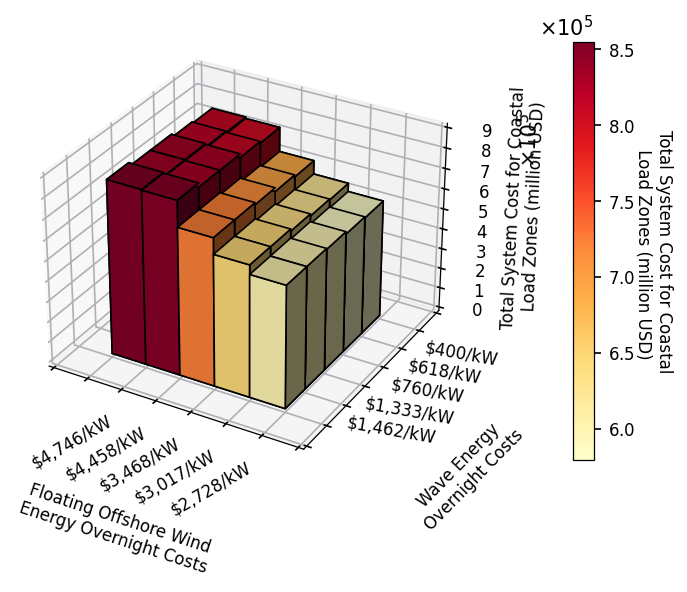

In [43]:
fig = plt.figure(dpi=150)
ax1 = fig.add_subplot(111, projection='3d')

x3 = [1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5]
y3 = [1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5]
z3 = np.zeros(25)

dx = np.ones(25)
dy = np.ones(25)
dz = cost_npv_by_scen_list

cmap = cm.get_cmap('YlOrRd')
norm = Normalize(vmin=round(min(cost_npv_by_scen_list),0), vmax=round(max(cost_npv_by_scen_list),1))
colors = cmap(norm(dz))

sc = cm.ScalarMappable(cmap=cmap,norm=norm)
sc.set_array([])
cbar = plt.colorbar(sc, fraction=0.03, pad = 0.15)
cbar.ax.set_ylabel('Total System Cost for Coastal\n Load Zones (million USD)', rotation=270, fontsize = 8, labelpad=18)
cbar.ax.tick_params(labelsize=8)

ax1.bar3d(x3, y3, z3, dx, dy, dz, color=colors)

ax1.set_xlabel('Floating Offshore Wind\nEnergy Overnight Costs',fontsize=8, labelpad=20)
ax1.set_ylabel('Wave Energy\nOvernight Costs',fontsize=8, labelpad=20)
ax1.set_zlabel('Total System Cost for Coastal\n Load Zones (million USD)',fontsize=8)
ax1.tick_params(axis='both', which='major', labelsize=8)

x_labels = [item.get_text() for item in ax1.get_xticklabels()]
x_labels[1] = '$4,746/kW'
x_labels[2] = '$4,458/kW'
x_labels[3] = '$3,468/kW'
x_labels[4] = '$3,017/kW'
x_labels[5] = '$2,728/kW'
ax1.set_xticklabels(x_labels)
plt.setp(ax1.get_xticklabels(), rotation=30)

y_labels = [item.get_text() for item in ax1.get_yticklabels()]
y_labels[3] = '$1,462/kW'
y_labels[4] = '$1,333/kW'
y_labels[5] = '$760/kW'
y_labels[6] = '$618/kW'
y_labels[7] = '$400/kW'
ax1.set_yticklabels(y_labels)
plt.setp(ax1.get_yticklabels(), rotation=-10)

plt.show()

In [32]:
cost_types=["GenVariableOMCosts", 
        "TxFixedCosts",
        "FuelCosts",
        "GenFixedCosts", 
        "EnergyStorageFixedCosts"]

/data/switch/wave_notebooks/ipykernel_2449491/3396909014.py:39: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  total_real_costs.T.to_latex(folder_to_save_results+"Real costs (Million USD) in PNM.tex",index=True,


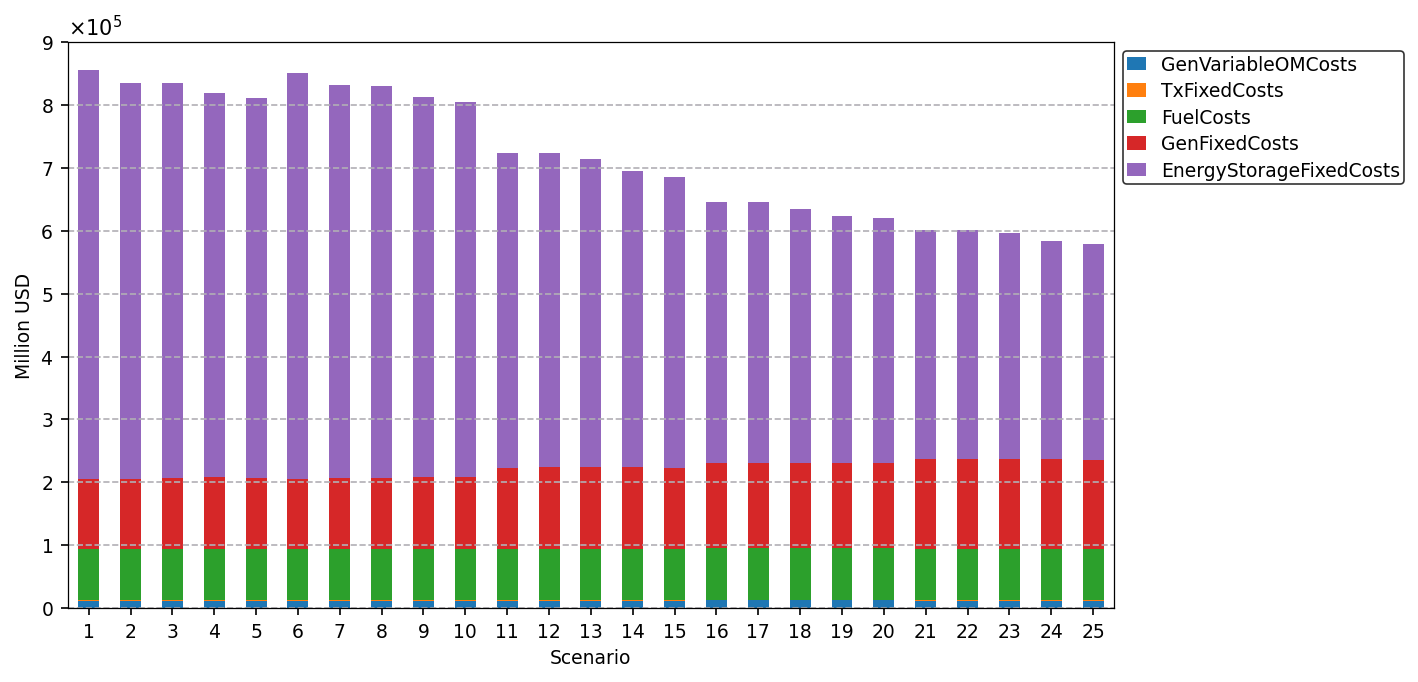

In [33]:
# Initialize figure environment
fig, ax = plt.subplots(figsize=(9,5), dpi=150)

#Set background of the graph
fig.patch.set_facecolor('white')

# Main plot
ax = total_npv_cost_by_scenario[cost_types].plot.bar(stacked=True,ax=ax, rot=0, lw=0)

# Label configuration
plt.xlabel("Scenario", fontsize=9)
plt.ylabel("Million USD", fontsize=9)
plt.yticks(fontsize=9)
plt.xticks(fontsize=9)

# Legend configuration
ax.legend(
    #handles[::-1],
    # labels[::-1],
    bbox_to_anchor=(1, 1),
    loc="upper left",
    fontsize=9,
    handlelength=1,
    frameon=True,
    edgecolor="black",
    facecolor="white",
)

#Axis configuration
ax.grid(axis='y', linestyle='dashed')

#Set background of the graph
ax.patch.set_facecolor('white')

plt.savefig(folder_to_save_results+"Real costs (Million USD) in PNM.png", transparent=False)

#Rename for spaces purposes
#data=costsNPV_by_scenario.rename(index=figure_names,inplace=False)
total_real_costs.T.to_latex(folder_to_save_results+"Real costs (Million USD) in PNM.tex",index=True,
                                  float_format='%.1f',
                                  caption="Real costs (Million USD) in PNM")



In [34]:
fname="loads.csv"
loads = get_data(scenario, fname, fpath='inputs')
loads.columns= loads.columns.str.lower()
loads=loads.loc[loads.load_zone.isin(analysis_zones)]
loads=loads.replace({"scenario": short_names})
loads

,load_zone,timepoint,zone_demand_mw,scenario
4608,CA_LADWP,88010,"3,033.00",1
4609,CA_LADWP,88014,"3,002.34",1
4610,CA_LADWP,88018,"2,417.03",1
4611,CA_LADWP,88022,"2,484.09",1
4612,CA_LADWP,88026,"3,189.45",1
...,...,...,...,...
26491,WA_W,359143,"5,879.78",25
26492,WA_W,359147,"5,255.94",25
26493,WA_W,359151,"5,279.17",25
26494,WA_W,359155,"5,016.20",25


In [35]:
fname="timestamps.csv"
timestamps = get_data(scenario, fname)
timestamps.replace({"scenario": short_names},inplace=True)
timestamps

exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exceptionexception

timestamp in column
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exceptionexception

timestamp in columntimestamp in column

exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exceptionexception

timestamp in columntimestamp in column

exception
timestamp in column


,timepoint,timestamp,hours_per_year,timeseries,period,scenario
0,88010,2020011602,113.56,2020_2020-01-16,2020,1
1,88014,2020011606,113.56,2020_2020-01-16,2020,1
2,88018,2020011610,113.56,2020_2020-01-16,2020,1
3,88022,2020011614,113.56,2020_2020-01-16,2020,1
4,88026,2020011618,113.56,2020_2020-01-16,2020,1
...,...,...,...,...,...,...
571,359143,2050122107,8.11,2050_2050-12-21,2050,25
572,359147,2050122111,8.11,2050_2050-12-21,2050,25
573,359151,2050122115,8.11,2050_2050-12-21,2050,25
574,359155,2050122119,8.11,2050_2050-12-21,2050,25


In [36]:
loads_with_timestamps = pd.merge(left=loads,right=timestamps, on=['timepoint','scenario'])
loads_with_timestamps

,load_zone,timepoint,zone_demand_mw,scenario,timestamp,hours_per_year,timeseries,period
0,CA_LADWP,88010,"3,033.00",1,2020011602,113.56,2020_2020-01-16,2020
1,CA_PGE_BAY,88010,"4,755.88",1,2020011602,113.56,2020_2020-01-16,2020
2,CA_PGE_CEN,88010,"3,263.28",1,2020011602,113.56,2020_2020-01-16,2020
3,CA_PGE_N,88010,"2,914.56",1,2020011602,113.56,2020_2020-01-16,2020
4,CA_PGE_S,88010,"1,102.53",1,2020011602,113.56,2020_2020-01-16,2020
...,...,...,...,...,...,...,...,...
172795,CA_SDGE,359159,"3,898.00",25,2050122123,8.11,2050_2050-12-21,2050
172796,MEX_BAJA,359159,"3,043.43",25,2050122123,8.11,2050_2050-12-21,2050
172797,OR_W,359159,"4,813.34",25,2050122123,8.11,2050_2050-12-21,2050
172798,WA_SEATAC,359159,"7,557.11",25,2050122123,8.11,2050_2050-12-21,2050


In [37]:
fname="timeseries.csv"
timeseries = get_data(scenario, fname, fpath='inputs')
timeseries

,TIMESERIES,ts_period,ts_duration_of_tp,ts_num_tps,ts_scale_to_period,scenario
0,2050_2050-01-13,2050,4.00,6,20.28,s1
1,2050_2050-01-21,2050,4.00,6,283.89,s1
2,2050_2050-02-22,2050,4.00,6,20.28,s1
3,2050_2050-02-25,2050,4.00,6,283.89,s1
4,2050_2050-03-02,2050,4.00,6,20.28,s1
...,...,...,...,...,...,...
91,2020_2020-10-31,2020,4.00,6,20.28,s25
92,2020_2020-11-07,2020,4.00,6,283.89,s25
93,2020_2020-11-29,2020,4.00,6,20.28,s25
94,2020_2020-12-14,2020,4.00,6,283.89,s25


In [38]:
ts_duration_of_tp = timeseries['ts_duration_of_tp'].unique()[0]
ts_duration_of_tp

4.0

In [39]:
loads_by_scenario= loads_with_timestamps .pivot_table(
    index=['scenario'], values="zone_demand_mw", aggfunc=np.sum )
loads_by_scenario=loads_by_scenario*ts_duration_of_tp 
loads_by_scenario.rename(columns={'zone_demand_mw':'total_zone_demand_MWh'},inplace=True)
loads_by_scenario['sc_order'] = loads_by_scenario.index.get_level_values('scenario').map(order)
loads_by_scenario=loads_by_scenario.sort_values('sc_order').drop('sc_order',axis=1)

loads_by_scenario
###use generation instead of load

,total_zone_demand_MWh
scenario,
1,"130,211,313.35"
2,"130,211,313.35"
3,"130,211,313.35"
4,"130,211,313.35"
5,"130,211,313.35"
6,"130,211,313.35"
7,"130,211,313.35"
8,"130,211,313.35"
9,"130,211,313.35"


In [40]:
total_npv_costs_w_load=pd.merge(left=total_npv_costs,right=loads_by_scenario, on=['scenario'])
total_npv_costs_w_load['USD/MWh']=total_npv_costs_w_load['Total Cost (million USD)']*10**6/total_npv_costs_w_load['total_zone_demand_MWh']
# total_npv_costs_w_load.drop(['zone_demand_mw'], axis=1, inplace=True)

#rename the columns
total_npv_costs_w_load.rename({'GenVariableOMCosts': 'Variable O&M Generation Costs'}, axis=1, inplace=True)
total_npv_costs_w_load.rename({'TxFixedCosts': 'Transmission Costs'}, axis=1, inplace=True)
total_npv_costs_w_load.rename({'FuelCosts': 'Fuel Costs'}, axis=1, inplace=True)
total_npv_costs_w_load.rename({'GenFixedCosts': 'Generation Fixed Costs'}, axis=1, inplace=True)
#total_npv_costs_w_load.rename({'StorageFixedCosts': 'Storage power capacity costs'}, axis=1, inplace=True)
total_npv_costs_w_load.rename({'EnergyStorageFixedCosts': 'Storage Energy Capacity Costs'}, axis=1, inplace=True)
total_npv_costs_w_load.rename({'total_zone_demand_MWh':'Total Energy Demand'}, axis=1, inplace=True)

total_npv_costs_w_load = total_npv_costs_w_load.pivot_table(
    index=['scenario'], values=['Generation Fixed Costs', 
                                                 'Variable O&M Generation Costs', 
                                                 'Fuel Costs', 
                                                 'Transmission Costs',
                                                 'Storage Energy Capacity Costs',
                                                 'Total Cost (million USD)',
                                                 'Total Energy Demand',
                                                 'USD/MWh'], aggfunc=np.sum )

#sort the columns
total_npv_costs_w_load=total_npv_costs_w_load[['Generation Fixed Costs', 
                                                 'Variable O&M Generation Costs', 
                                                 'Fuel Costs', 
                                                 'Transmission Costs',
                                                 'Storage Energy Capacity Costs',
                                                 'Total Cost (million USD)',
                                                 'Total Energy Demand',
                                                 'USD/MWh']]

total_npv_costs_w_load['sc_order'] = total_npv_costs_w_load.index.map(order)
total_npv_costs_w_load = total_npv_costs_w_load.sort_values('sc_order').drop('sc_order',axis=1)
total_npv_costs_w_load

,Generation Fixed Costs,Variable O&M Generation Costs,Fuel Costs,Transmission Costs,Storage Energy Capacity Costs,Total Cost (million USD),Total Energy Demand,USD/MWh
scenario,,,,,,,,
1,"110,322.47","12,154.92","81,608.94",679.83,"650,085.60","854,851.76","520,845,253.39","6,565.11"
2,"111,418.09","12,119.66","81,307.12",532.44,"630,031.77","835,409.09","520,845,253.39","6,415.79"
3,"112,499.48","12,120.74","81,294.03",311.56,"628,918.41","835,144.21","520,845,253.39","6,413.76"
4,"114,001.28","12,159.75","81,539.55",199.73,"610,579.06","818,479.36","520,845,253.39","6,285.78"
5,"113,687.50","12,165.75","81,552.78",198.43,"602,765.59","810,370.06","520,845,253.39","6,223.50"
6,"111,112.63","12,162.12","81,684.74",679.81,"645,710.81","851,350.12","520,845,253.39","6,538.22"
7,"112,289.38","12,128.52","81,389.76",526.32,"625,067.01","831,400.99","520,845,253.39","6,385.01"
8,"113,361.55","12,120.23","81,327.77",308.32,"623,334.32","830,452.19","520,845,253.39","6,377.73"
9,"114,608.62","12,161.37","81,569.28",196.38,"603,970.77","812,506.43","520,845,253.39","6,239.91"


In [41]:
total_npv_costs_w_load.T.to_latex(folder_to_save_results+"Real costs (Million USD) in PNM with price.tex",index=True,
                                  float_format='%.1f',
                                  caption="Real costs (Million USD) in PNM")

/data/switch/wave_notebooks/ipykernel_2449491/2429244955.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  total_npv_costs_w_load.T.to_latex(folder_to_save_results+"Real costs (Million USD) in PNM with price.tex",index=True,
